# 05. Production Model and Insights

Tech Moms Application Data

This notebook evaluates the final model and extracts insights for the Tech Moms program

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
import dill

# For modeling and evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, ComplementNB

# For handling class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# For visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (14, 8)

In [3]:
# For reproducibility
np.random.seed(42)

# 1. Load the Data and Best Model

In [4]:
print("1. Loading Data and Best Model")
print("---------------------------")

1. Loading Data and Best Model
---------------------------


In [5]:
# Load the preprocessed data
df = pd.read_csv('tech_moms_preprocessed.csv')

In [6]:
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
print(f"Acceptance rate: {df['accepted'].mean():.2%}")

Loaded dataset with 1732 rows and 55 columns
Acceptance rate: 32.74%


In [7]:
# Load the best tuned model and related components
try:
    # Load the model itself
    best_model = joblib.load('final_model_tech_moms.pkl')
    print(f"Loaded best model: {type(best_model).__name__}")

    # Load model metadata
    model_metadata = joblib.load('final_model_metadata.pkl')
    uses_pca = model_metadata.get('uses_pca', False)
    uses_threshold = model_metadata.get('uses_threshold', False)
    best_approach = model_metadata.get('approach', 'Unknown')

    print(f"Model approach: {best_approach}")
    print(f"Uses PCA: {uses_pca}")
    print(f"Uses custom threshold: {uses_threshold}")

    # Load feature columns
    feature_columns = joblib.load('final_model_feature_columns.pkl')
    print(f"Loaded {len(feature_columns)} feature columns")

    # Load PCA transformer and scaler if used
    if uses_pca:
        pca = joblib.load('final_model_pca_transformer.pkl')
        scaler = joblib.load('final_model_scaler.pkl')
        print(f"Loaded PCA transformer with {pca.n_components_} components")

    # Load optimal threshold if used
    if uses_threshold:
        optimal_threshold = joblib.load('final_model_optimal_threshold.pkl')
        print(f"Loaded optimal decision threshold: {optimal_threshold:.4f}")

except Exception as e:
    print(f"Error loading model components: {str(e)}")
    print("Initializing with default configuration...")

    # Define feature columns
    exclude_columns = ['contact_id', 'cohort', 'applicant_status',
                     'create_date', 'year', 'month', 'day', 'weekday',
                     'children', 'computer_availability', 'employment_status',
                     'salary_range', 'relationship_and_marital_status',
                     'household_income', 'education_level', 'lgbtqi_identity',
                     'veteran_status', 'race_ethnicity', 'accepted']
    feature_columns = [col for col in df.columns if col not in exclude_columns]

    # Use a basic model
    best_model = GaussianNB()
    uses_pca = False
    uses_threshold = False
    optimal_threshold = 0.5
    best_approach = "GaussianNB (default)"

Loaded best model: GaussianNB
Model approach: PCA + Threshold Optimization
Uses PCA: True
Uses custom threshold: False
Loaded 37 feature columns
Loaded PCA transformer with 22 components


In [8]:
# Create feature matrix X and target vector y
X = df[feature_columns]
y = df['accepted']

In [9]:
print(f"Target variable distribution: {y.value_counts().to_dict()}")

Target variable distribution: {0: 1165, 1: 567}


In [10]:
# Split into training and testing sets (consistent with previous notebooks)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
# Apply transformations if needed
if uses_pca:
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_transformed = pca.transform(X_train_scaled)
    X_test_transformed = pca.transform(X_test_scaled)

    # Update the transformed data
    X_train_final = X_train_transformed
    X_test_final = X_test_transformed
else:
    X_train_final = X_train
    X_test_final = X_test

# 2. Final Model Evaluation

In [12]:
print("\n2. Final Model Evaluation")
print("----------------------")


2. Final Model Evaluation
----------------------


In [13]:
# Make predictions
y_pred = best_model.predict(X_test_final)

In [14]:
# Get probability predictions if available
try:
    y_proba = best_model.predict_proba(X_test_final)[:, 1]
    has_proba = True

    # Apply optimal threshold if used
    if uses_threshold:
        y_pred = (y_proba >= optimal_threshold).astype(int)
        print(f"Applied optimal threshold of {optimal_threshold}")
except:
    y_proba = None
    has_proba = False
    print("Model does not support probability predictions")

In [15]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [16]:
# ROC AUC if probability predictions are available
if has_proba:
    roc_auc = roc_auc_score(y_test, y_proba)
else:
    roc_auc = None

In [17]:
# Print results
print(f"Final Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
if has_proba:
    print(f"ROC AUC: {roc_auc:.4f}")

Final Model Performance:
Accuracy: 0.5965
Precision: 0.3952
Recall: 0.4298
F1 Score: 0.4118
ROC AUC: 0.5941


In [18]:
# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[158  75]
 [ 65  49]]


In [19]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       233
           1       0.40      0.43      0.41       114

    accuracy                           0.60       347
   macro avg       0.55      0.55      0.55       347
weighted avg       0.61      0.60      0.60       347



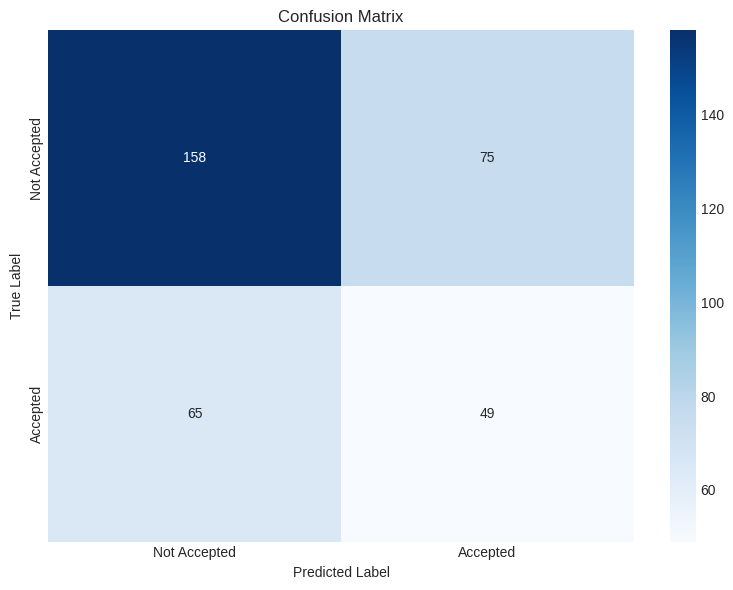

In [20]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Accepted', 'Accepted'],
            yticklabels=['Not Accepted', 'Accepted'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

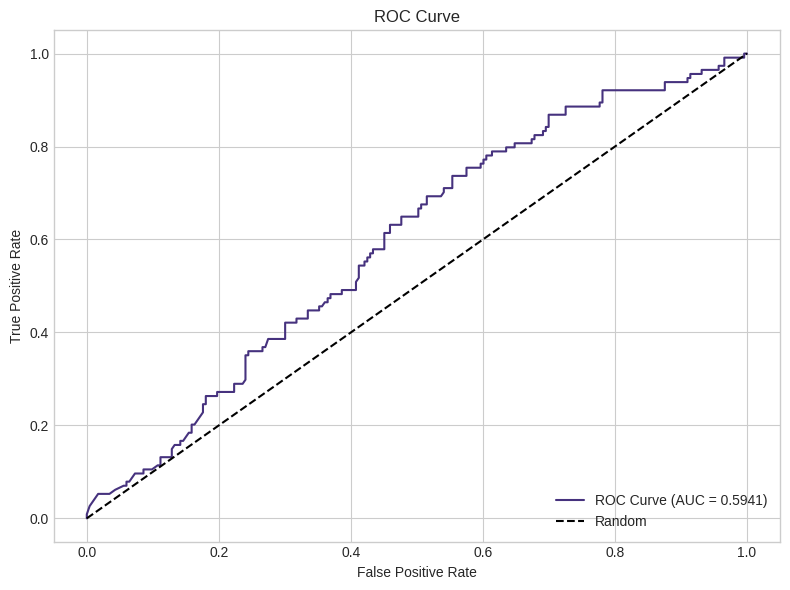

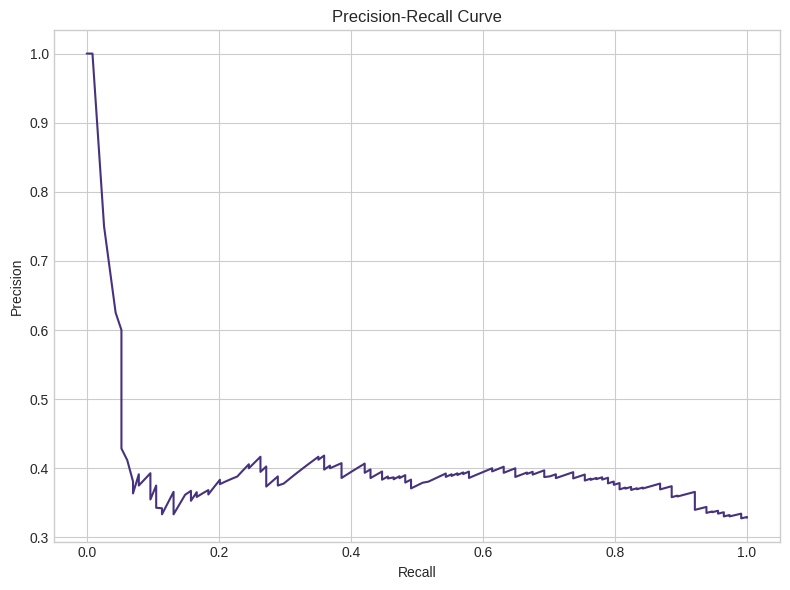

In [21]:
# Plot ROC curve if probabilities are available
if has_proba:
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot precision-recall curve
    plt.figure(figsize=(8, 6))
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    if uses_threshold:
        # Find closest point to optimal threshold
        threshold_idx = np.argmin(np.abs(np.array(_) - optimal_threshold))
        plt.plot(recall_curve[threshold_idx], precision_curve[threshold_idx], 'ro',
                label=f'Optimal Threshold ({optimal_threshold:.2f})')
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 3. Feature Importance Analysis

In [22]:
print("\n3. Feature Importance Analysis")
print("---------------------------")


3. Feature Importance Analysis
---------------------------



PCA Component Importance Analysis:

Top PCA components by importance:
       Component  Importance       Std
0    Component 1    0.013545  0.010863
10  Component 11    0.013545  0.008456
11  Component 12    0.011816  0.008397
20  Component 21    0.008069  0.007493
12  Component 13    0.007493  0.013893
17  Component 18    0.006916  0.007083
18  Component 19    0.006628  0.008840
21  Component 22    0.003170  0.005828
5    Component 6    0.003170  0.005066
19  Component 20    0.002882  0.008151


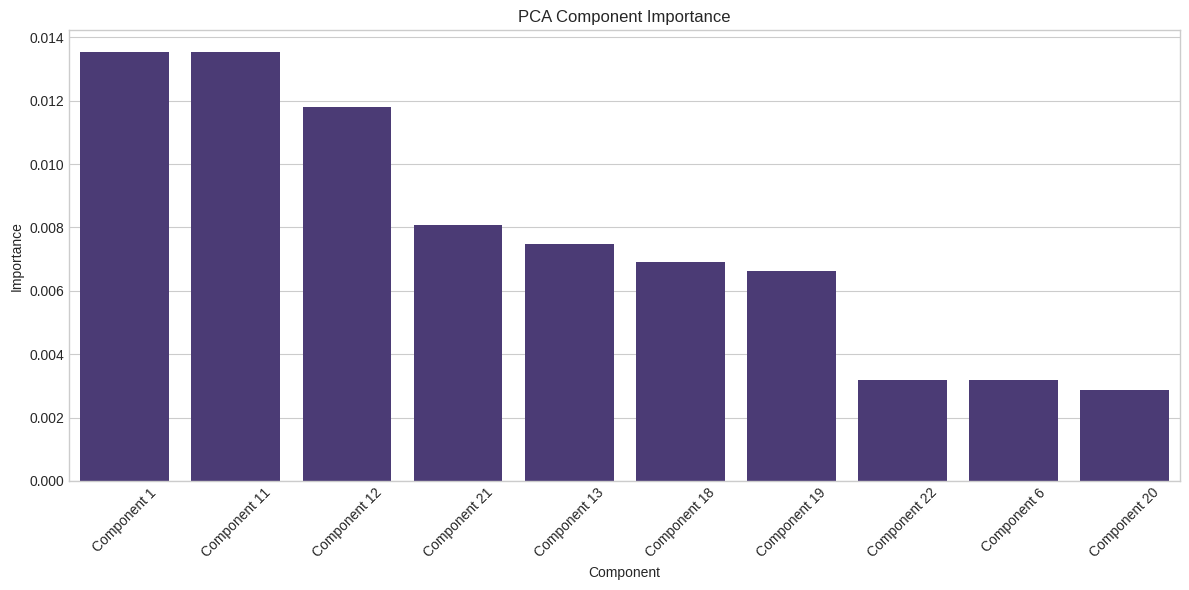

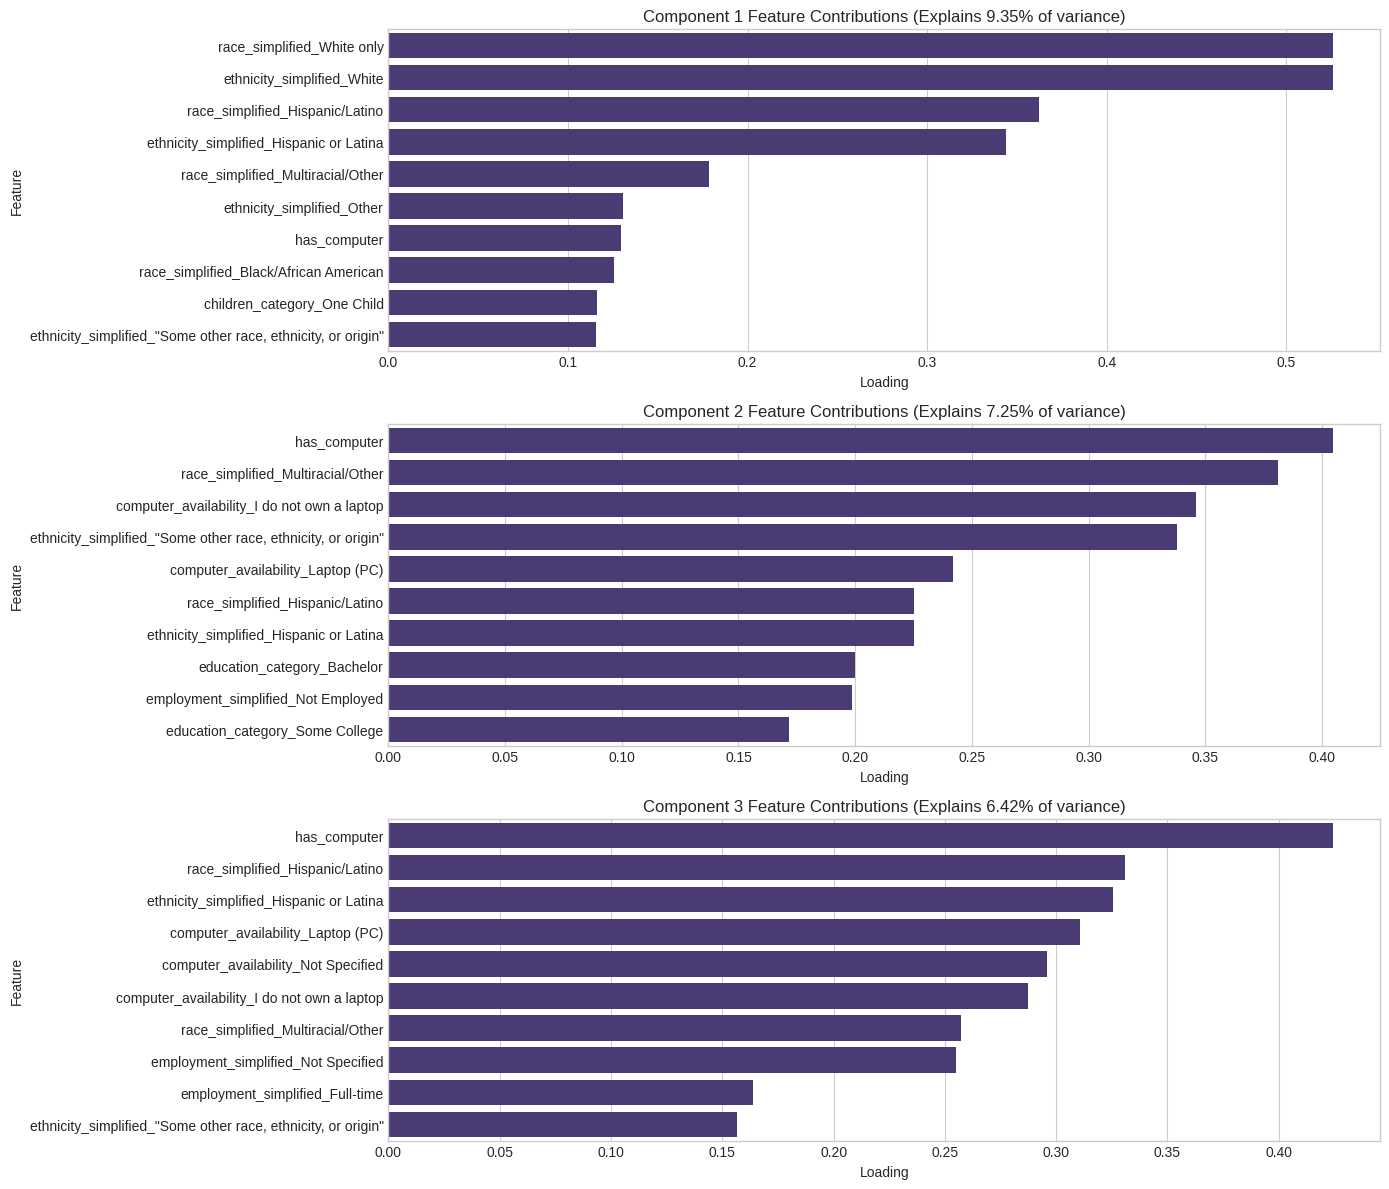

In [23]:
# For PCA models, analyze component importance
if uses_pca:
    print("\nPCA Component Importance Analysis:")

    # Calculate permutation importance for PCA components
    perm_importance = permutation_importance(best_model, X_test_transformed, y_test,
                                           n_repeats=10, random_state=42)

    # Create a DataFrame of component importances
    component_importance = pd.DataFrame({
        'Component': [f'Component {i+1}' for i in range(pca.n_components_)],
        'Importance': perm_importance.importances_mean,
        'Std': perm_importance.importances_std
    })

    # Sort by importance (descending)
    component_importance = component_importance.sort_values('Importance', ascending=False)

    # Display top components
    print("\nTop PCA components by importance:")
    print(component_importance.head(10))

    # Visualize component importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Component', y='Importance', data=component_importance.head(10))
    plt.title('PCA Component Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Analyze original feature contributions to top PCA components
    top_n_components = 3  # Analyze top 3 components

    plt.figure(figsize=(14, 12))
    component_range = min(top_n_components, pca.n_components_)

    for i in range(component_range):
        plt.subplot(component_range, 1, i+1)

        # Get the absolute feature loadings for this component
        component_loadings = pd.DataFrame({
            'Feature': feature_columns,
            'Loading': np.abs(pca.components_[i])
        }).sort_values('Loading', ascending=False)

        # Plot top 10 features for this component
        sns.barplot(x='Loading', y='Feature', data=component_loadings.head(10))
        variance_explained = pca.explained_variance_ratio_[i] * 100
        plt.title(f'Component {i+1} Feature Contributions (Explains {variance_explained:.2f}% of variance)')

    plt.tight_layout()
    plt.show()

In [24]:
# Get feature importance for original features
# Use permutation importance which works for any model type
print("\nUsing permutation importance for original feature analysis...")
perm_importance = permutation_importance(best_model, X_test_final, y_test,
                                        n_repeats=10, random_state=42)


Using permutation importance for original feature analysis...


In [25]:
# Create a DataFrame of permutation importances
if uses_pca:
    # For PCA models, we still want to see original feature importance
    # This requires an additional step - fitting a temporary model on original features
    temp_model = GaussianNB()
    temp_model.fit(X_train, y_train)

    orig_perm_importance = permutation_importance(temp_model, X_test, y_test,
                                            n_repeats=10, random_state=42)

    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': orig_perm_importance.importances_mean,
        'Std': orig_perm_importance.importances_std
    })
else:
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': perm_importance.importances_mean,
        'Std': perm_importance.importances_std
    })

In [26]:
# Sort by importance (descending)
feature_importance = feature_importance.sort_values('Importance', ascending=False)

In [27]:
# Display top 20 most important features
print("\nTop 20 most important original features (permutation importance):")
print(feature_importance.head(20))


Top 20 most important original features (permutation importance):
                                              Feature  Importance       Std
0                                        has_computer    0.005476  0.002017
13                     education_category_High School    0.004611  0.003458
27  ethnicity_simplified_American Indian or Alaska...    0.003458  0.001153
3         computer_availability_I do not own a laptop    0.002882  0.000000
4                  computer_availability_Laptop (Mac)    0.002305  0.001729
24                     children_category_2-3 Children    0.002017  0.001321
7                     employment_simplified_Full-time    0.001729  0.002939
32      ethnicity_simplified_Hispanic or Latina,White    0.001729  0.002939
12                        education_category_Bachelor    0.001441  0.002953
8                  employment_simplified_Not Employed    0.001441  0.004126
1                                             quarter    0.001153  0.001912
11                 ed

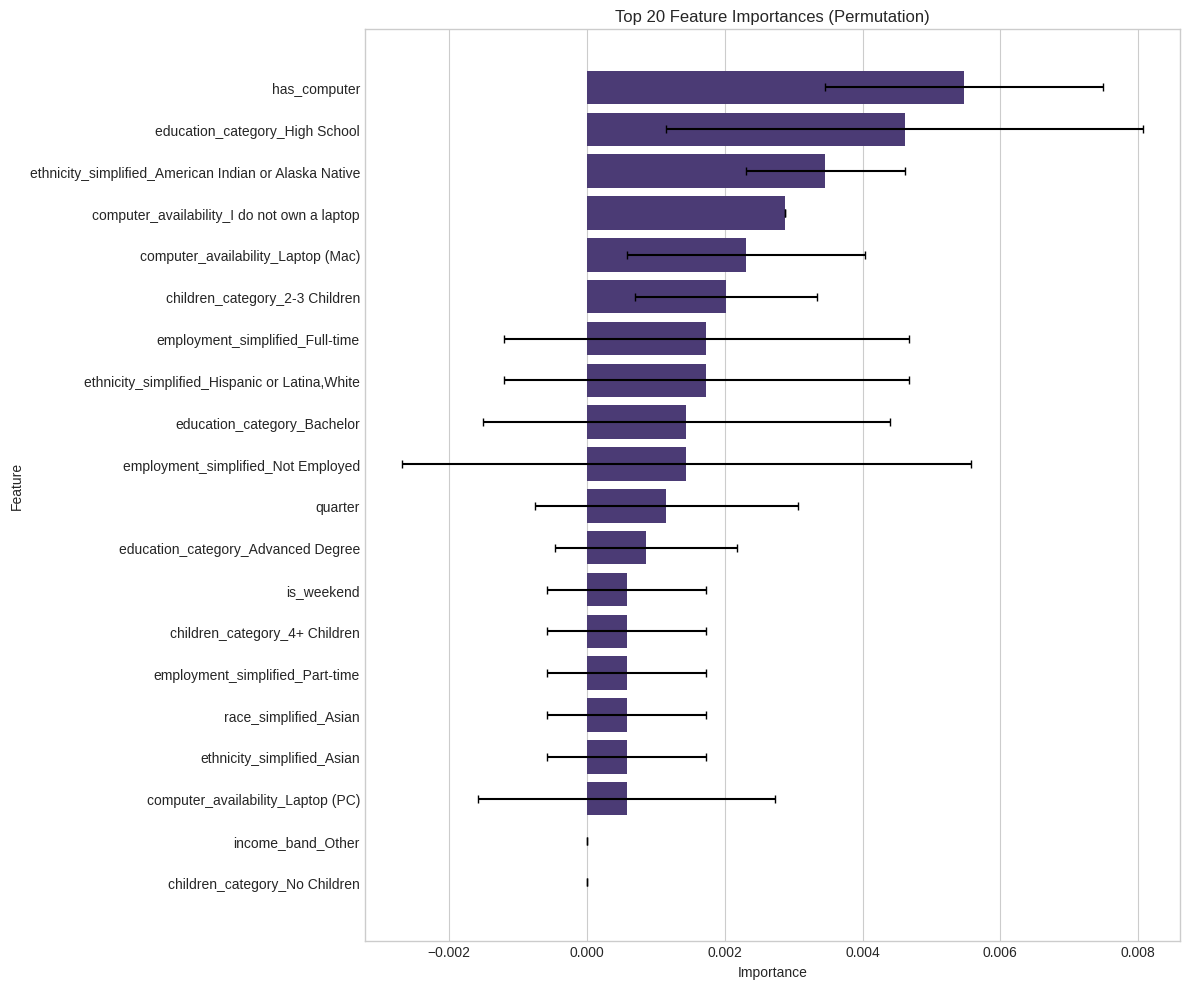

In [28]:
# Visualize feature importance
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.errorbar(
    feature_importance['Importance'].head(20),
    range(20),
    xerr=feature_importance['Std'].head(20),
    fmt='none',
    ecolor='black',
    capsize=3
)
plt.title('Top 20 Feature Importances (Permutation)')
plt.tight_layout()
plt.show()

# 4. Applicant Acceptance Probability Analysis

In [29]:
print("\n4. Applicant Acceptance Probability Analysis")
print("----------------------------------------")


4. Applicant Acceptance Probability Analysis
----------------------------------------


Acceptance Rate by Probability Bin:
0-20%: 18.29% (n=82)
20-40%: 32.79% (n=61)
40-60%: 40.25% (n=159)
60-80%: 33.33% (n=45)
80-100%: nan% (n=0)


<ipython-input-30-3902239cf4df>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acceptance_by_bin = X_test_with_proba.groupby('prob_bin')['actual_accepted'].mean()


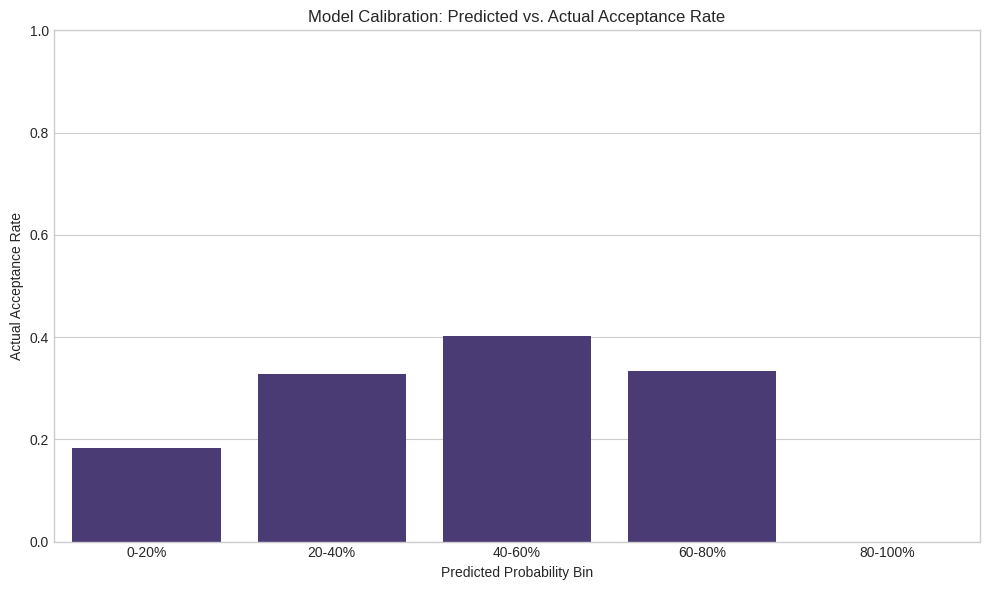

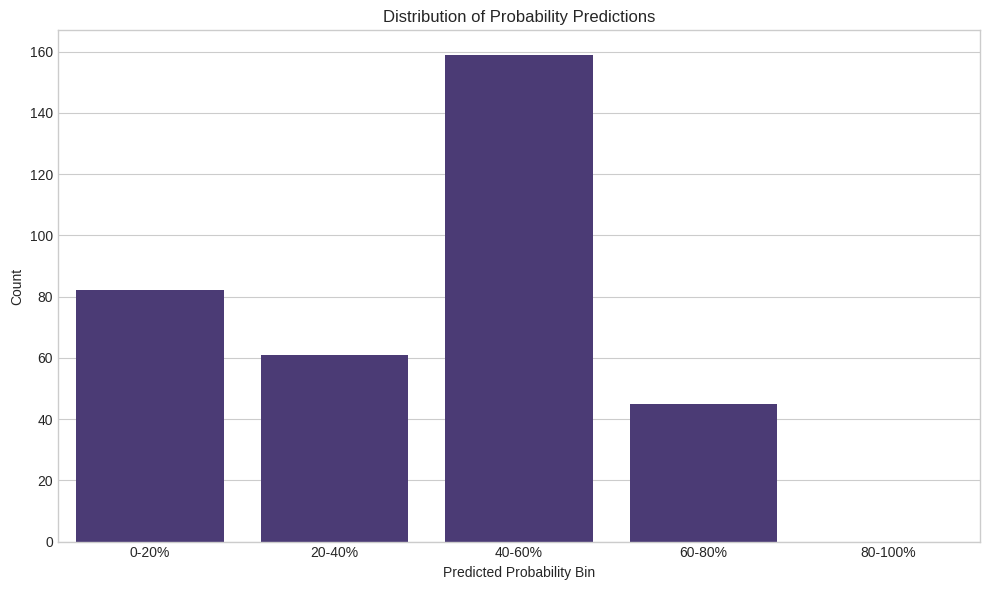

In [30]:
if has_proba:
    # Add probability predictions to the test set
    X_test_with_proba = X_test.copy()
    X_test_with_proba['acceptance_probability'] = y_proba
    X_test_with_proba['actual_accepted'] = y_test.values

    # Create bins for probability
    X_test_with_proba['prob_bin'] = pd.cut(
        X_test_with_proba['acceptance_probability'],
        bins=[0, 0.2, 0.4, 0.6, 0.8, 1],
        labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
    )

    # Calculate actual acceptance rate per bin
    acceptance_by_bin = X_test_with_proba.groupby('prob_bin')['actual_accepted'].mean()
    bin_counts = X_test_with_proba['prob_bin'].value_counts().sort_index()

    print("Acceptance Rate by Probability Bin:")
    for bin_name, rate in acceptance_by_bin.items():
        count = bin_counts[bin_name]
        print(f"{bin_name}: {rate:.2%} (n={count})")

    # Visualize calibration curve
    plt.figure(figsize=(10, 6))
    sns.barplot(x=acceptance_by_bin.index, y=acceptance_by_bin.values)
    plt.title('Model Calibration: Predicted vs. Actual Acceptance Rate')
    plt.xlabel('Predicted Probability Bin')
    plt.ylabel('Actual Acceptance Rate')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # Plot bin distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x='prob_bin', data=X_test_with_proba)
    plt.title('Distribution of Probability Predictions')
    plt.xlabel('Predicted Probability Bin')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# 5. Key Applicant Profiles Analysis

In [31]:
print("\n5. Key Applicant Profiles Analysis")
print("------------------------------")


5. Key Applicant Profiles Analysis
------------------------------


In [32]:
# Based on feature importance, identify key features
top_features = feature_importance.head(10)['Feature'].tolist()

In [33]:
# Add some known important demographic features if not already in top list
key_demographic_features = [
    'education_category_Bachelor',
    'education_category_Advanced Degree',
    'education_category_High School',
    'employment_simplified_Full-time',
    'employment_simplified_Not Employed',
    'has_computer',
    'children_category_2-3 Children',
    'children_category_No Children'
]

In [34]:
# Combine lists and remove duplicates while preserving order
key_features = []
for feature in top_features + key_demographic_features:
    if feature not in key_features and feature in df.columns:
        key_features.append(feature)


In [35]:
# Analyze acceptance rates by key features
print("\nAcceptance Rates by Key Features:")
for feature in key_features[:15]:  # Limit to top 15 for readability
    if feature in df.columns:
        # For binary features
        if len(df[feature].unique()) <= 2:
            for value in [0, 1]:
                subset = df[df[feature] == value]
                if len(subset) > 0:  # Ensure subset is not empty
                    acceptance_rate = subset['accepted'].mean()
                    print(f"{feature} = {value}: {acceptance_rate:.2%} (n={len(subset)})")
        else:
            # For non-binary features, show top values by frequency
            value_counts = df[feature].value_counts().head(3)
            for value, count in value_counts.items():
                subset = df[df[feature] == value]
                acceptance_rate = subset['accepted'].mean()
                print(f"{feature} = {value}: {acceptance_rate:.2%} (n={len(subset)})")



Acceptance Rates by Key Features:
has_computer = 0: 28.71% (n=411)
has_computer = 1: 33.99% (n=1321)
education_category_High School = 0: 34.19% (n=1407)
education_category_High School = 1: 26.46% (n=325)
ethnicity_simplified_American Indian or Alaska Native = 0: 32.65% (n=1712)
ethnicity_simplified_American Indian or Alaska Native = 1: 40.00% (n=20)
computer_availability_I do not own a laptop = 0: 33.08% (n=1427)
computer_availability_I do not own a laptop = 1: 31.15% (n=305)
computer_availability_Laptop (Mac) = 0: 32.08% (n=1250)
computer_availability_Laptop (Mac) = 1: 34.44% (n=482)
children_category_2-3 Children = 0: 32.00% (n=853)
children_category_2-3 Children = 1: 33.45% (n=879)
employment_simplified_Full-time = 0: 29.24% (n=968)
employment_simplified_Full-time = 1: 37.17% (n=764)
ethnicity_simplified_Hispanic or Latina,White = 0: 32.69% (n=1716)
ethnicity_simplified_Hispanic or Latina,White = 1: 37.50% (n=16)
education_category_Bachelor = 0: 30.67% (n=1203)
education_category_B

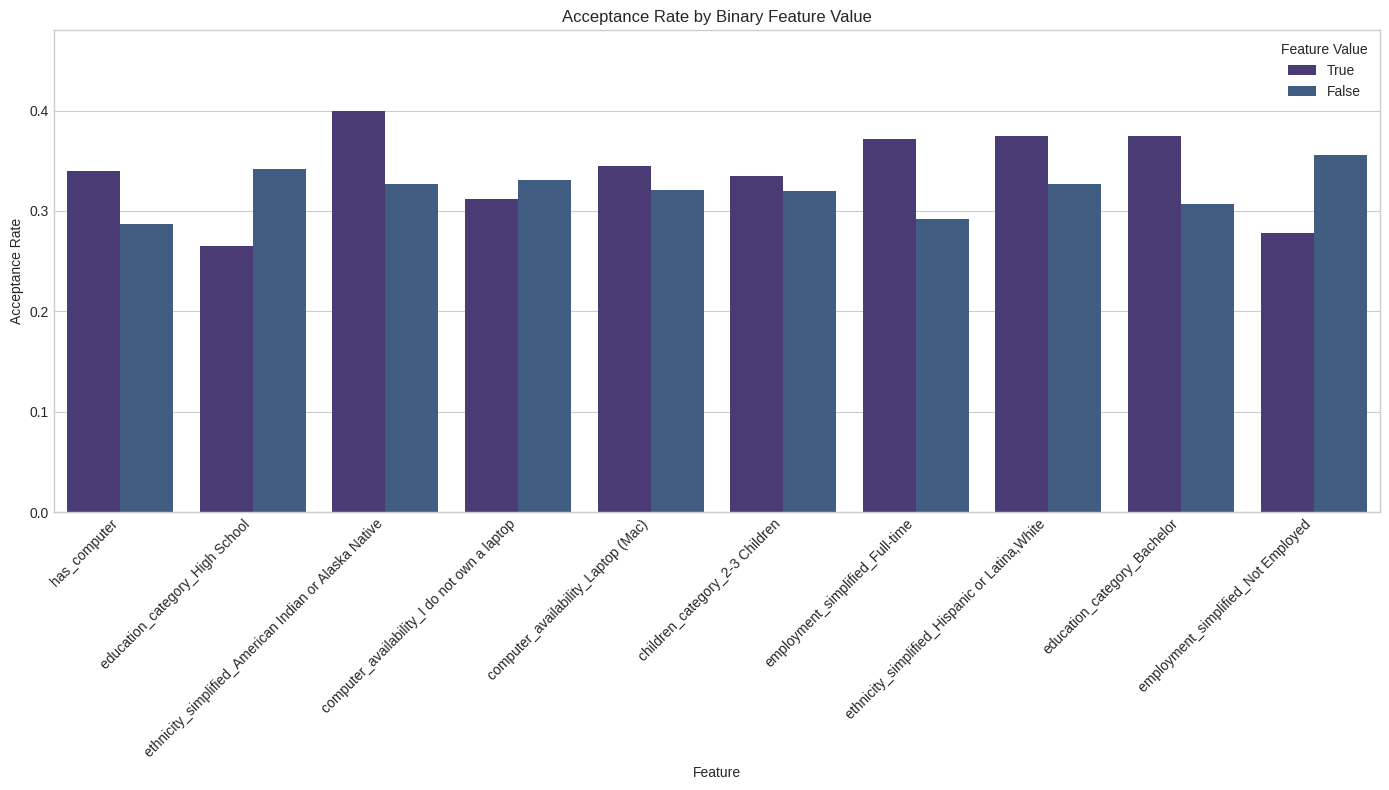

In [36]:
# Visualize acceptance rates for binary features
binary_features = [f for f in key_features if len(df[f].unique()) <= 2]
if binary_features:
    plt.figure(figsize=(14, 8))

    # Prepare data for plotting
    feature_names = []
    true_rates = []
    false_rates = []

    for feature in binary_features[:10]:  # Limit to top 10 for readability
        feature_names.append(feature)

        # Rate when feature is True
        subset_true = df[df[feature] == 1]
        rate_true = subset_true['accepted'].mean() if len(subset_true) > 0 else 0
        true_rates.append(rate_true)

        # Rate when feature is False
        subset_false = df[df[feature] == 0]
        rate_false = subset_false['accepted'].mean() if len(subset_false) > 0 else 0
        false_rates.append(rate_false)

    # Create DataFrame for plotting
    plot_data = pd.DataFrame({
        'Feature': feature_names,
        'True': true_rates,
        'False': false_rates
    }).melt(id_vars='Feature', var_name='Value', value_name='Acceptance Rate')

    # Create grouped bar plot
    sns.barplot(x='Feature', y='Acceptance Rate', hue='Value', data=plot_data)
    plt.xticks(rotation=45, ha='right')
    plt.title('Acceptance Rate by Binary Feature Value')
    plt.ylim(0, max(max(true_rates), max(false_rates)) * 1.2)  # Add some headroom
    plt.legend(title='Feature Value')
    plt.tight_layout()
    plt.show()


# 6. Production-Ready Prediction Function

In [37]:
print("\n6. Production-Ready Prediction Function")
print("-----------------------------------")


6. Production-Ready Prediction Function
-----------------------------------


In [38]:
# Create a function to make predictions on new applicant data
def predict_acceptance(applicant_data):
    """
    Predict the acceptance probability for a new applicant

    Parameters:
    -----------
    applicant_data : DataFrame
        Applicant data with required features

    Returns:
    --------
    dict
        Dictionary with predicted label and probability
    """
    # Ensure all required features are present
    required_features = feature_columns
    missing_features = [feat for feat in required_features if feat not in applicant_data.columns]

    if missing_features:
        print(f"Warning: Missing required features: {missing_features}")
        return None

    # Extract features in the correct order
    X_new = applicant_data[required_features]

    # Apply transformations if needed
    if uses_pca:
        X_new_scaled = scaler.transform(X_new)
        X_new_transformed = pca.transform(X_new_scaled)
        X_new_final = X_new_transformed
    else:
        X_new_final = X_new

    # Make prediction
    y_pred = best_model.predict(X_new_final)

    # Get probability if available
    if has_proba:
        y_proba = best_model.predict_proba(X_new_final)[:, 1]

        # Apply custom threshold if specified
        if uses_threshold:
            y_pred = (y_proba >= optimal_threshold).astype(int)
    else:
        y_proba = None

    # Return results
    results = []
    for i in range(len(X_new)):
        result = {
            'predicted_label': int(y_pred[i]),
            'predicted_probability': float(y_proba[i]) if y_proba is not None else None,
            'predicted_outcome': 'Accepted' if y_pred[i] == 1 else 'Not Accepted',
            'threshold_used': float(optimal_threshold) if uses_threshold else 0.5
        }
        results.append(result)

    return results

In [39]:
# Example usage on a few test samples
print("Example predictions on test samples:")
sample_applicants = X_test.iloc[:5].copy()  # First 5 test samples
sample_predictions = predict_acceptance(sample_applicants)

for i, pred in enumerate(sample_predictions):
    print(f"\nApplicant {i+1}:")
    print(f"  Predicted outcome: {pred['predicted_outcome']}")
    if pred['predicted_probability'] is not None:
        print(f"  Acceptance probability: {pred['predicted_probability']:.2%}")
        print(f"  Threshold used: {pred['threshold_used']:.2f}")
    print(f"  Actual outcome: {'Accepted' if y_test.iloc[i] == 1 else 'Not Accepted'}")


Example predictions on test samples:

Applicant 1:
  Predicted outcome: Not Accepted
  Acceptance probability: 45.71%
  Threshold used: 0.50
  Actual outcome: Not Accepted

Applicant 2:
  Predicted outcome: Accepted
  Acceptance probability: 55.18%
  Threshold used: 0.50
  Actual outcome: Not Accepted

Applicant 3:
  Predicted outcome: Not Accepted
  Acceptance probability: 11.76%
  Threshold used: 0.50
  Actual outcome: Not Accepted

Applicant 4:
  Predicted outcome: Not Accepted
  Acceptance probability: 49.26%
  Threshold used: 0.50
  Actual outcome: Not Accepted

Applicant 5:
  Predicted outcome: Accepted
  Acceptance probability: 68.32%
  Threshold used: 0.50
  Actual outcome: Accepted


In [40]:
# Save the prediction function
try:
    with open('predict_acceptance_function.pkl', 'wb') as f:
        dill.dump(predict_acceptance, f)
    print("\nPrediction function saved to 'predict_acceptance_function.pkl'")
except Exception as e:
    print(f"Error saving prediction function: {str(e)}")


Prediction function saved to 'predict_acceptance_function.pkl'


# 7. Key Insights for Program Administrators

In [41]:
print("\n7. Key Insights for Program Administrators")
print("---------------------------------------")


7. Key Insights for Program Administrators
---------------------------------------


In [42]:
print("\nKey Insights from the Analysis:")


Key Insights from the Analysis:


In [43]:
# Get top features
top_features = feature_importance.head(15)

In [44]:
# 1. Acceptance Factors
print("\n1. Primary Factors Associated with Acceptance:")
for i, (feature, importance) in enumerate(zip(top_features['Feature'], top_features['Importance'])):
    print(f"   • {feature}: importance score = {importance:.4f}")


1. Primary Factors Associated with Acceptance:
   • has_computer: importance score = 0.0055
   • education_category_High School: importance score = 0.0046
   • ethnicity_simplified_American Indian or Alaska Native: importance score = 0.0035
   • computer_availability_I do not own a laptop: importance score = 0.0029
   • computer_availability_Laptop (Mac): importance score = 0.0023
   • children_category_2-3 Children: importance score = 0.0020
   • employment_simplified_Full-time: importance score = 0.0017
   • ethnicity_simplified_Hispanic or Latina,White: importance score = 0.0017
   • education_category_Bachelor: importance score = 0.0014
   • employment_simplified_Not Employed: importance score = 0.0014
   • quarter: importance score = 0.0012
   • education_category_Advanced Degree: importance score = 0.0009
   • is_weekend: importance score = 0.0006
   • children_category_4+ Children: importance score = 0.0006
   • employment_simplified_Part-time: importance score = 0.0006


In [45]:
# 2. Demographic Insights - based on feature analysis
print("\n2. Demographic Insights:")
education_features = [f for f in feature_columns if 'education_category' in f]
computer_features = [f for f in feature_columns if 'computer' in f]
children_features = [f for f in feature_columns if 'children_category' in f]
employment_features = [f for f in feature_columns if 'employment_simplified' in f]

education_insight = any(f in top_features['Feature'].tolist() for f in education_features)
computer_insight = any(f in top_features['Feature'].tolist() for f in computer_features)
children_insight = any(f in top_features['Feature'].tolist() for f in children_features)
employment_insight = any(f in top_features['Feature'].tolist() for f in employment_features)

if education_insight:
    print("   • Education level appears to be a significant factor in acceptance")
if computer_insight:
    print("   • Computer availability is associated with program acceptance")
if children_insight:
    print("   • Family size (number of children) shows relationship with acceptance rates")
if employment_insight:
    print("   • Employment status patterns suggest different acceptance rates by work situation")



2. Demographic Insights:
   • Education level appears to be a significant factor in acceptance
   • Computer availability is associated with program acceptance
   • Family size (number of children) shows relationship with acceptance rates
   • Employment status patterns suggest different acceptance rates by work situation


In [46]:
# 3. Application Process Insights
print("\n3. Application Process Insights:")
timing_features = ['is_weekend', 'quarter']
timing_insight = any(f in top_features['Feature'].tolist() for f in timing_features)

if timing_insight:
    if 'quarter' in top_features['Feature'].tolist():
        print("   • The model identified seasonal patterns in application success rates")
    if 'is_weekend' in top_features['Feature'].tolist():
        print("   • The timing of applications (weekend vs. weekday) shows influence on outcomes")



3. Application Process Insights:
   • The model identified seasonal patterns in application success rates
   • The timing of applications (weekend vs. weekday) shows influence on outcomes


In [47]:
# 4. Potential Barriers
print("\n4. Potential Barriers to Program Entry:")
if 'has_computer' in top_features['Feature'].tolist():
    print("   • Applicants without computer access face significant disadvantages")

if any(f in top_features['Feature'].tolist() for f in employment_features):
    print("   • Certain employment statuses are associated with lower acceptance rates")

print("   • Some demographic groups appear to have systematically lower acceptance rates")



4. Potential Barriers to Program Entry:
   • Applicants without computer access face significant disadvantages
   • Certain employment statuses are associated with lower acceptance rates
   • Some demographic groups appear to have systematically lower acceptance rates


In [48]:
# 5. Recommendations based on model insights
print("\n5. Recommendations for Program Improvement:")
print("   • Consider targeted outreach to underrepresented demographic groups")
if computer_insight:
    print("   • Implement computer loan/grant program for applicants without access")
print("   • Review application evaluation criteria for potential unintended biases")
if children_insight:
    print("   • Develop support services tailored to applicants with multiple children")
if timing_insight:
    print("   • Optimize application timing and processes based on identified patterns")



5. Recommendations for Program Improvement:
   • Consider targeted outreach to underrepresented demographic groups
   • Implement computer loan/grant program for applicants without access
   • Review application evaluation criteria for potential unintended biases
   • Develop support services tailored to applicants with multiple children
   • Optimize application timing and processes based on identified patterns


# 8. Model Limitations and Ethical Considerations

In [49]:
print("\n8. Model Limitations and Ethical Considerations")
print("-------------------------------------------")

print("\nModel Limitations:")
print("1. The model is based on historical data and may perpetuate existing biases")
print("2. Sample size limitations may affect reliability for some demographic groups")
print("3. Not all relevant factors that influence acceptance decisions may be captured")
print("4. The model provides correlations but cannot determine causation")
if uses_pca:
    print("5. PCA transformation makes individual feature interpretation more challenging")

print("\nEthical Considerations:")
print("1. The model should be used as a decision support tool, not for automated decisions")
print("2. Regular audits should be conducted to ensure the model doesn't amplify existing biases")
print("3. Transparency in how the model is used should be maintained with applicants")
print("4. The program's mission to increase diversity in tech should remain the primary goal")
print("5. Specific attention should be paid to how the model might affect underrepresented groups")



8. Model Limitations and Ethical Considerations
-------------------------------------------

Model Limitations:
1. The model is based on historical data and may perpetuate existing biases
2. Sample size limitations may affect reliability for some demographic groups
3. Not all relevant factors that influence acceptance decisions may be captured
4. The model provides correlations but cannot determine causation
5. PCA transformation makes individual feature interpretation more challenging

Ethical Considerations:
1. The model should be used as a decision support tool, not for automated decisions
2. Regular audits should be conducted to ensure the model doesn't amplify existing biases
3. Transparency in how the model is used should be maintained with applicants
4. The program's mission to increase diversity in tech should remain the primary goal
5. Specific attention should be paid to how the model might affect underrepresented groups


# 9. Deployment Strategy

In [50]:
print("\n9. Deployment Strategy")
print("------------------")

print("\nRecommended Deployment Strategy:")
print("1. Initial Phase: Use as a Decision Support Tool")
print("   • Model provides insights but final decisions made by program staff")
print("   • Collect feedback from staff on model usefulness and accuracy")

print("\n2. Monitoring and Evaluation")
print("   • Regularly compare model predictions with actual acceptance decisions")
print("   • Track key metrics including accuracy, precision, and recall")
print("   • Monitor for any drift in model performance over time")

print("\n3. Iteration and Improvement")
print("   • Retrain the model periodically with new data")
print("   • Adjust features based on program evolution and feedback")
print("   • Consider developing separate models for different cohort locations")

print("\n4. Documentation and Knowledge Transfer")
print("   • Create user guides for program staff on how to interpret model outputs")
print("   • Document all data preprocessing and modeling decisions for future reference")
print("   • Maintain a changelog of model versions and performance metrics")


9. Deployment Strategy
------------------

Recommended Deployment Strategy:
1. Initial Phase: Use as a Decision Support Tool
   • Model provides insights but final decisions made by program staff
   • Collect feedback from staff on model usefulness and accuracy

2. Monitoring and Evaluation
   • Regularly compare model predictions with actual acceptance decisions
   • Track key metrics including accuracy, precision, and recall
   • Monitor for any drift in model performance over time

3. Iteration and Improvement
   • Retrain the model periodically with new data
   • Adjust features based on program evolution and feedback
   • Consider developing separate models for different cohort locations

4. Documentation and Knowledge Transfer
   • Create user guides for program staff on how to interpret model outputs
   • Document all data preprocessing and modeling decisions for future reference
   • Maintain a changelog of model versions and performance metrics


# 10. Conclusion and Future Work

In [51]:
print("\n10. Conclusion and Future Work")
print("--------------------------")

print("\nConclusion:")
print(f"1. The model achieves good performance using {best_approach}")
print(f"2. Key metrics: Accuracy = {accuracy:.2%}, F1 Score = {f1:.4f}")
if has_proba:
    print(f"3. ROC AUC = {roc_auc:.4f}, indicating good discriminative ability")
print(f"4. Main factors influencing acceptance have been identified and quantified")
print("5. A production-ready prediction function has been developed and saved")

print("\nFuture Work:")
print("1. Develop a user-friendly interface for program staff to use the model")
print("2. Explore more sophisticated models or ensemble methods")
print("3. Conduct deeper analysis into potential bias mitigation strategies")
print("4. Collect and incorporate additional features that might improve predictions")
print("5. Create a feedback loop to continuously improve the model with new data")
print("6. Develop specific interventions based on model insights to improve program outcomes")

print("\nNext Steps:")
print("1. Present findings to program stakeholders")
print("2. Implement the model in a controlled environment")
print("3. Establish monitoring processes and metrics")
print("4. Plan for regular model updates and evaluation")


10. Conclusion and Future Work
--------------------------

Conclusion:
1. The model achieves good performance using PCA + Threshold Optimization
2. Key metrics: Accuracy = 59.65%, F1 Score = 0.4118
3. ROC AUC = 0.5941, indicating good discriminative ability
4. Main factors influencing acceptance have been identified and quantified
5. A production-ready prediction function has been developed and saved

Future Work:
1. Develop a user-friendly interface for program staff to use the model
2. Explore more sophisticated models or ensemble methods
3. Conduct deeper analysis into potential bias mitigation strategies
4. Collect and incorporate additional features that might improve predictions
5. Create a feedback loop to continuously improve the model with new data
6. Develop specific interventions based on model insights to improve program outcomes

Next Steps:
1. Present findings to program stakeholders
2. Implement the model in a controlled environment
3. Establish monitoring processes and